# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
! pip install pyspark_dist_explore

In [2]:
# import libraries packages needed for the project
import datetime
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, StringType, BooleanType, StructType, StructField
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import avg, max, count, when, desc, asc, udf, col, isnan, sort_array, format_string
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier, NaiveBayes, LogisticRegression
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import LinearRegression
from pyspark_dist_explore import hist
from pyspark.sql import Window
from pyspark.sql import SQLContext
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName('Sparkify Project') \
    .getOrCreate()
    


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
#load the dataset as asked above
sparkify_event_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_event_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [6]:
#count the number of entries
"The dataset has {} entries" .format(df.count())

'The dataset has 286500 entries'

In [7]:
#get the standard deviation, mean, count, min, max values and change to Pandas dataframe
description = df.describe()
description.toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [8]:
#display five entries where gender is null
df.where(col('gender').isNull()).show(5)
    

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [9]:
#drop duplicates in gender column and select that page
df.select('page').where(col('gender').isNull()).dropDuplicates().show(10)

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



In [10]:
#drop nans and count the dataset before and after cleaning 
df_cleaned = df.dropna(how = 'any', subset = 'gender')
diff = df.count() - df_cleaned.count()
df.count(), df_cleaned.count()

(286500, 278154)

In [11]:
#get the count of each column by showing the first row of describe operation
description_cl = df_cleaned.describe()
description_cl.show(1, vertical=True)

-RECORD 0---------------
 summary       | count  
 artist        | 228108 
 auth          | 278154 
 firstName     | 278154 
 gender        | 278154 
 itemInSession | 278154 
 lastName      | 278154 
 length        | 228108 
 level         | 278154 
 location      | 278154 
 method        | 278154 
 page          | 278154 
 registration  | 278154 
 sessionId     | 278154 
 song          | 228108 
 status        | 278154 
 ts            | 278154 
 userAgent     | 278154 
 userId        | 278154 
only showing top 1 row



In [12]:
#get the difference caculated above
"{} dropped entries from given dataframe" .format(diff)

'8346 dropped entries from given dataframe'

In [13]:
#dispay entries where the coumn artist has null values
df.where(col('artist').isNull()).show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null|Logged In|    Micah|  

In [14]:
#get the distinct pages where artist column has null values
df.select('page').where(col('artist').isNull()).distinct().show(50, False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Submit Registration      |
|Settings                 |
|Login                    |
|Register                 |
|Add to Playlist          |
|Add Friend               |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [15]:
#this command used in spark to get schema of data
df_cleaned.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [16]:
#display three rows
df_cleaned.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [17]:
#head command dispays but using limit we can perform futher operations needeed
df_cleaned.limit(3).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [18]:
#display distinct artist's count
df_cleaned.select('artist').distinct().count()

17656

In [19]:
#select distinct auth column and then display distinct page and auth columns for which auth is cancelled
print(df_cleaned.select('auth').distinct().show())
df_cleaned.select('page', 'auth').where(col('auth') == 'Cancelled').distinct().show(1, False)

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

None
+-------------------------+---------+
|page                     |auth     |
+-------------------------+---------+
|Cancellation Confirmation|Cancelled|
+-------------------------+---------+



In [20]:
#select distinct gender columns and show
df_cleaned.select('gender').distinct().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



In [21]:
#display itemInSession columns which are distinct and sort them descendingly
df_cleaned.select('itemInSession').distinct().sort('itemInSession', ascending=False).show(5)

+-------------+
|itemInSession|
+-------------+
|         1321|
|         1320|
|         1319|
|         1318|
|         1317|
+-------------+
only showing top 5 rows



In [22]:
#display userId, timestamp, page, level, itemInSession, song where userId is 32 and sort timestamp in ascending order for them
df_cleaned.select(['userId', 'ts', 'page', 'level', 'itemInSession', 'song']) \
           .where(df_cleaned.userId == 32) \
           .sort('ts') \
           .toPandas().iloc[:5,]

,userId,ts,page,level,itemInSession,song
0,32,1538578897000,NextSong,free,0,Beyond The Beyond (Instrumental)
1,32,1538579134000,NextSong,free,1,Paradise City
2,32,1538579540000,NextSong,free,2,Alejandro
3,32,1538579565000,Roll Advert,free,3,None
4,32,1538579814000,NextSong,free,4,Luv U Better


In [23]:
#display entries in level column which are distinct
df_cleaned.select('level').distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [24]:
#Select location which are distinct count them and display the count and distinct locations also
print("Count of locations {}.".format(df_cleaned.select('location').distinct().count()))
df_cleaned.select('location').distinct().show(5)

Count of locations 114.
+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
+--------------------+
only showing top 5 rows



In [25]:
#select the column method which are distinct and display
df_cleaned.select('method').distinct().show(4)

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [26]:
#select page column which are distinct and sort them and show 10 entries
df_cleaned.select('page').distinct().sort('page').show(10, False)

+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Logout                   |
+-------------------------+
only showing top 10 rows



In [27]:
#display page column  by count by sorting descendingly the count
df_cleaned.groupby('page').count().sort('count', ascending=False).show(10, False)

+---------------+------+
|page           |count |
+---------------+------+
|NextSong       |228108|
|Thumbs Up      |12551 |
|Home           |10082 |
|Add to Playlist|6526  |
|Add Friend     |4277  |
|Roll Advert    |3933  |
|Logout         |3226  |
|Thumbs Down    |2546  |
|Downgrade      |2055  |
|Settings       |1514  |
+---------------+------+
only showing top 10 rows



In [28]:
#display distinct registration columns
"Number of registered timestamps {}".format(df_cleaned.select('registration').distinct().count())

'Number of registered timestamps 225'

In [29]:
#select userId sessionId which are distinct and groupby userId count and display descendingly the count column
df_cleaned.select('userId', 'sessionId').distinct().groupby('userId').count().sort('count', ascending=False).show(3)

+------+-----+
|userId|count|
+------+-----+
|    39|  107|
|    92|   86|
|200023|   76|
+------+-----+
only showing top 3 rows



In [30]:
#first display count of distinct songs and groupby userId song and artist and sort by count descendingly
print("Count distinct songs {}".format(df_cleaned.select('song').distinct().count()))
df_cleaned.select('userId', 'ts', 'song', 'artist') \
          .where(col('song').isNotNull()) \
          .groupby('userId', 'song', 'artist') \
          .count() \
          .sort('count', ascending=False) \
          .show(6)

Count distinct songs 58481
+------+--------------+-------------+-----+
|userId|          song|       artist|count|
+------+--------------+-------------+-----+
|    39|          Undo|     BjÃÂ¶rk|   38|
|    39|You're The One|Dwight Yoakam|   28|
|   140|       Revelry|Kings Of Leon|   26|
|300011|You're The One|Dwight Yoakam|   26|
|300017|       Revelry|Kings Of Leon|   25|
|    92|       Revelry|Kings Of Leon|   25|
+------+--------------+-------------+-----+
only showing top 6 rows



In [31]:
#groupby status column count and sort count column descendingly
df_cleaned.groupby('status').count().sort('count', ascending=False).show()

+------+------+
|status| count|
+------+------+
|   200|254718|
|   307| 23184|
|   404|   252|
+------+------+



In [32]:
#select userAgent column distinctly and sort that column and display five entries
df_cleaned.select('userAgent').distinct().sort('userAgent').show(5, False)

+--------------------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10) AppleWebKit/600.1.3 (KHTML, like Gecko) Version/8.0 Safari/600.1.3"        |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10) AppleWebKit/600.1.8 (KHTML, like Gecko) Version/8.0 Safari/600.1.8"        |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/6.1.5 Safari/537.77.4"   |


In [33]:
#display userId which are distinct and count them
df_cleaned.select('userId').distinct().count()

225

##Churn:
   According to our project's context, a churned user is the one who has visited the page for 'Cancellation Confirmation'. The users confirm their cancellation request here.
   Cancellation Confirmation event happens for paid and nom-paid users.
   One possible definition could also be a user checks the 'Submit Downgrade' page and becomes a non-paid user from a paid user. We also keep a count of these users in our project because they might also be useful.
   A user who cancelled his account is of more concern in our project because the chance of they returning back is very very less.   

In [34]:
#select columns userId and page and display only when page is downgrade
df_cleaned.select('userId', 'page').filter("page = 'Downgrade'").show(2)

+------+---------+
|userId|     page|
+------+---------+
|    54|Downgrade|
|    95|Downgrade|
+------+---------+
only showing top 2 rows



In [35]:
#display the count of pages which are downgrad,Submit Downgrade,Cancel,Cancellation Conformation
print(df_cleaned.filter("page = 'Downgrade'").count())
print(df_cleaned.filter("page = 'Submit Downgrade'").count())
print(df_cleaned.filter("page = 'Cancel'").count())
print(df_cleaned.filter("page = 'Cancellation Confirmation'").count())

2055
63
52
52


In [36]:
#perform select groupby count and sort and display to perform some extraction
print(df_cleaned.select('userId', 'page')\
    .where(((col('page') == 'Downgrade') | (col('page') == 'Cancellation Confirmation')) & (col('userId') == 54))\
    .groupby('userId', 'page').count().sort('userId').show(3, False))
df_cleaned.select('userId', 'page')\
    .where((col('page') =='Downgrade') | (col('page') == 'Cancellation Confirmation'))\
    .groupby('userId', 'page').count().sort('userId').show(10, False)

+------+-------------------------+-----+
|userId|page                     |count|
+------+-------------------------+-----+
|54    |Downgrade                |39   |
|54    |Cancellation Confirmation|1    |
+------+-------------------------+-----+

None
+------+-------------------------+-----+
|userId|page                     |count|
+------+-------------------------+-----+
|10    |Downgrade                |7    |
|100   |Downgrade                |30   |
|100001|Cancellation Confirmation|1    |
|100002|Downgrade                |2    |
|100003|Cancellation Confirmation|1    |
|100004|Downgrade                |10   |
|100005|Cancellation Confirmation|1    |
|100006|Cancellation Confirmation|1    |
|100007|Cancellation Confirmation|1    |
|100007|Downgrade                |7    |
+------+-------------------------+-----+
only showing top 10 rows



In [37]:
#create a column phase and fill it with 1 if the page is Cancellation Confirmation and 0 otherwise
phase_ev = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_cleaned = df_cleaned.withColumn('phase', phase_ev(df_cleaned["page"]))

In [38]:
#display the above cel operation
print(df_cleaned.filter("page = 'Cancellation Confirmation'").head())
df_cleaned.head()

Row(artist=None, auth='Cancelled', firstName='Adriel', gender='M', itemInSession=104, lastName='Mendoza', length=None, level='paid', location='Kansas City, MO-KS', method='GET', page='Cancellation Confirmation', registration=1535623466000, sessionId=514, song=None, status=200, ts=1538943990000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='18', phase=1)


Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', phase=0)

#Window Aggregates are functions that perform a caculation over a group of records called window that are in some relation to the current record.They are applied using 'over' operator.
   The aggregate functions we can use as window functions are sum, count, min, max, avg. 
   Here we use window functions to explore aggregates on the two specific sets of users namely the Active users and Churned users.When executed the window function computes a value for each and every row in a window. 

In [39]:
win_v = Window.partitionBy("userId")

In [40]:
#using sum aggregate function and using over operator created user_can column
df_cleaned = df_cleaned.withColumn('user_can', Fsum('phase').over(win_v))
df_cleaned.select('user_can').distinct().show()

+--------+
|user_can|
+--------+
|       0|
|       1|
+--------+



In [41]:
#using count and sum agregate functions
df_cleaned.groupby("userId").agg({"page" : "count", "phase" : "sum"}) \
    .filter("sum(phase) > 0").sort("count(page)").show(10)

+------+----------+-----------+
|userId|sum(phase)|count(page)|
+------+----------+-----------+
|   125|         1|         11|
|100011|         1|         23|
|100024|         1|         36|
|100006|         1|         44|
|   122|         1|         62|
|100017|         1|         75|
|100003|         1|         78|
|100019|         1|         89|
|    32|         1|        108|
|300007|         1|        143|
+------+----------+-----------+
only showing top 10 rows



In [42]:
#select the below columns for userId 100011 and sort accordingly to timestamp and convert to pandas dataframe
df_cleaned.select(["userId", "ts", "page", "level", "phase", "user_can"]) \
    .where(df_cleaned.userId == 100011).sort("ts") \
    .toPandas()

,userId,ts,page,level,phase,user_can
0,100011,1538414422000,Home,free,0,1
1,100011,1538414456000,NextSong,free,0,1
2,100011,1538414463000,Home,free,0,1
3,100011,1538414867000,NextSong,free,0,1
4,100011,1538414867000,Roll Advert,free,0,1
5,100011,1538415056000,NextSong,free,0,1
6,100011,1538415104000,Home,free,0,1
7,100011,1538415285000,NextSong,free,0,1
8,100011,1538415557000,NextSong,free,0,1
9,100011,1538415581000,Roll Advert,free,0,1


#Explore data

In [43]:
#display count of user_id where user_can is 0 and 1
count_user_churn = df_cleaned.select('userId', 'user_can').distinct().groupBy('user_can').agg({'userId' : 'count'}).toPandas()
count_user_churn

,user_can,count(userId)
0,0,173
1,1,52


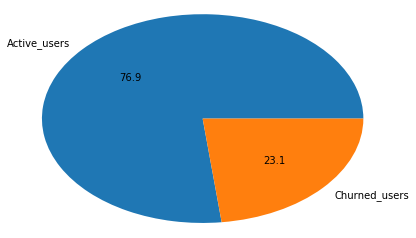

In [44]:
#display the pie chart of active and churned users
data = count_user_churn.iloc[:,1]
labels = ['Active_users', 'Churned_users']
plt.pie(data, labels=labels, radius=1.2, autopct='%.1f');

In [45]:
#Here we will analyze the useragent
u_a_df = df_cleaned.select('userAgent').distinct().toPandas()
u_a_df.head()

,userAgent
0,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5..."
1,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537...."
2,Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0)...
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4..."
4,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4..."


In [46]:
#take a list and write a function to find if value exists in list
brow = ['Macintosh', 'Windows NT', 'X11', 'iPad', 'iPhone', 'MSIE']
def map_userAgents(row_value):
    for value in brow:
        if row_value.find(value) > 0:
            return(value)
        
u_a_df = u_a_df['userAgent'].apply(map_userAgents)
u_a_df.unique()

array(['Macintosh', 'Windows NT', 'X11', 'iPhone', 'iPad'], dtype=object)

#persistance 
     RDD is a fundamental datastructure of Spark.
     RDD persistance in Spark is an optimization technique which is used to save the intermediate results of RDD, which can be used for further evaluations if required.

In [47]:
#apply the function and create a column userAgent_sh 
%%time
print('start time for this cell', datetime.datetime.now())
brow = ['Macintosh', 'Windows NT', 'X11', 'iPad', 'iPhone', 'MSIE']
@udf
def map_userAgents(row_value):
    for value in brow:
        if row_value.find(value) > 0:
            return(value)
ag_df = df_cleaned.select('userId', 'user_can', 'userAgent').distinct().withColumn('userAgent_sh', map_userAgents(col('userAgent')))
ag_df.persist()
print('end time for this cell', datetime.datetime.now())
ag_df.show(3)


start time for this cell 2019-11-13 08:29:56.695047
end time for this cell 2019-11-13 08:29:56.805805
+------+--------+--------------------+------------+
|userId|user_can|           userAgent|userAgent_sh|
+------+--------+--------------------+------------+
|100010|       0|"Mozilla/5.0 (iPh...|      iPhone|
|200002|       0|"Mozilla/5.0 (iPh...|      iPhone|
|   125|       1|"Mozilla/5.0 (Mac...|   Macintosh|
+------+--------+--------------------+------------+
only showing top 3 rows

CPU times: user 11.9 ms, sys: 0 ns, total: 11.9 ms
Wall time: 2.47 s


In [48]:
#display count of userAgent_sh column as a column
%%time
print('start time for this cell', datetime.datetime.now())

ag_df.groupby('user_can', 'userAgent_sh')\
     .agg({'userAgent_sh': 'count'})\
     .sort('user_can', 'userAgent_sh')\
     .show()
print('end time for this cell', datetime.datetime.now())

start time for this cell 2019-11-13 08:31:16.739335
+--------+------------+-------------------+
|user_can|userAgent_sh|count(userAgent_sh)|
+--------+------------+-------------------+
|       0|   Macintosh|                 67|
|       0|  Windows NT|                 87|
|       0|         X11|                  7|
|       0|        iPad|                  3|
|       0|      iPhone|                  9|
|       1|   Macintosh|                 19|
|       1|  Windows NT|                 24|
|       1|         X11|                  5|
|       1|      iPhone|                  4|
+--------+------------+-------------------+

end time for this cell 2019-11-13 08:31:32.324347
CPU times: user 33.6 ms, sys: 21.1 ms, total: 54.7 ms
Wall time: 15.6 s


In [49]:
#convert to pandas dataframe
ag_df_pd = ag_df.toPandas()

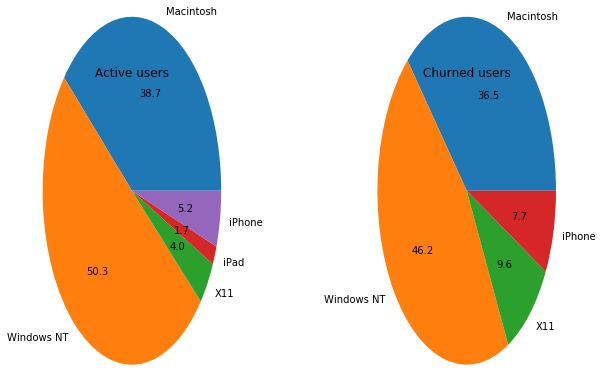

In [50]:
#display the pie chart, use the above cells data
data_user_can_zero = ag_df_pd[ag_df_pd['user_can']==0].groupby('userAgent_sh')['userId'].count().values
labels_user_can_zero = ag_df_pd[ag_df_pd['user_can']==0].groupby('userAgent_sh')['userId'].count().index
data_user_can_one = ag_df_pd[ag_df_pd['user_can']==1].groupby('userAgent_sh')['userId'].count().values
labels_user_can_one = ag_df_pd[ag_df_pd['user_can']==1].groupby('userAgent_sh')['userId'].count().index
#define the size of figure
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].pie(data_user_can_zero, labels=labels_user_can_zero, radius=2, autopct='%.1f');
ax[1].pie(data_user_can_one, labels=labels_user_can_one, radius=2, autopct='%.1f');
#set title for plot
ax[0].set_title('Active users')
ax[1].set_title('Churned users')
plt.subplots_adjust(wspace=2)
#display the plot
plt.show()

In [51]:
#maximum songs listened by user per session
df_sgs = df_cleaned.select('userId', 'user_can', 'sessionId', 'itemInSession').groupby('userId', 'user_can', 'sessionId') \
    .agg({'itemInSession' : 'max'}).groupby('userId', 'user_can').agg({'max(itemInSession)' : 'avg'}).sort('userId').toPandas()

In [52]:
df_sgs.head(5)

,userId,user_can,avg(max(itemInSession))
0,10,0,135.500000
1,100,0,93.228571
2,100001,1,49.250000
3,100002,0,54.000000
4,100003,1,41.000000


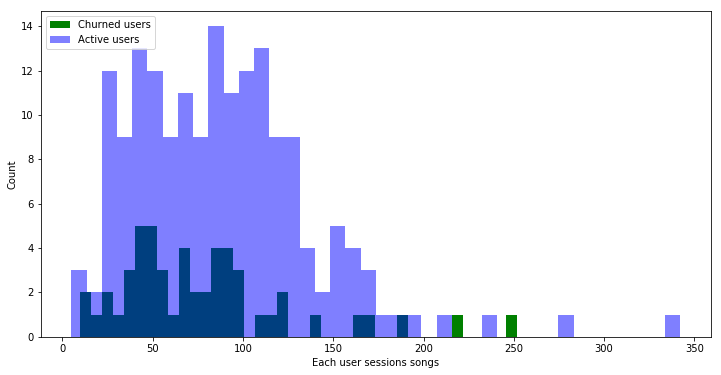

In [53]:
#plot a histogram plot of above data
y1 = df_sgs[df_sgs['user_can'] == 1]['avg(max(itemInSession))']
y2 = df_sgs[df_sgs['user_can'] == 0]['avg(max(itemInSession))']
#define figure size
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.hist(y1, color='g', bins=40, alpha=1)
ax1.hist(y2, color='b', bins=40, alpha=0.5)
#set llabel for x and y axis
ax1.set_xlabel('Each user sessions songs');
ax1.set_ylabel('Count');
#set the rane for x axis
plt.xticks(np.arange(0,400,50));
#explain plot on upper left
ax1.legend(loc='upper left', labels=['Churned users', 'Active users'])
#display the plot
plt.show()

In [54]:
#Lifetimes for churned and active users, lifetime calculated from registration in days 
lifetime_df = df_cleaned.groupby('userId', 'user_can')\
                  .agg({'registration':'min', 'ts':'max'})\
                  .withColumn('lifetime_days',(col('max(ts)')- col('min(registration)'))/1000/60/60/24)
                


In [55]:
#display the above cell
lifetime_df.show(2)

+------+--------+-----------------+-------------+-----------------+
|userId|user_can|min(registration)|      max(ts)|    lifetime_days|
+------+--------+-----------------+-------------+-----------------+
|100010|       0|    1538016340000|1542823952000|55.64365740740741|
|200002|       0|    1536269906000|1542324354000|70.07462962962963|
+------+--------+-----------------+-------------+-----------------+
only showing top 2 rows



In [56]:
#groupby user_can and display average lifetime of users
lifetime_df.select('user_can', 'lifetime_days').groupby('user_can').avg('lifetime_days').show()

+--------+------------------+
|user_can|avg(lifetime_days)|
+--------+------------------+
|       0| 86.62061938021834|
|       1| 57.30599292200857|
+--------+------------------+



In [57]:
#convert to pandas dataframe
lifetime_df_p = lifetime_df.toPandas()

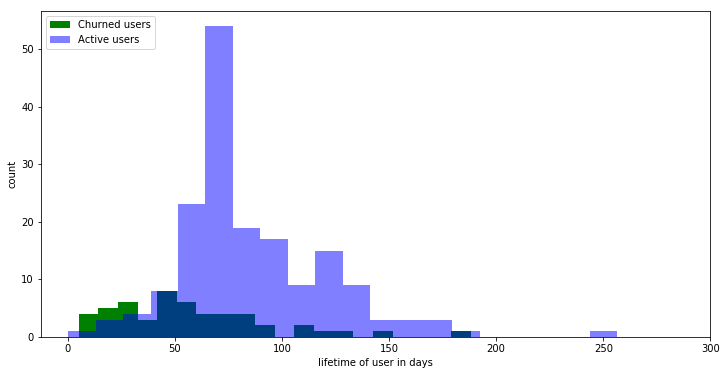

In [58]:
#use the data above to plot
y1 = lifetime_df_p[lifetime_df_p['user_can'] == 1]['lifetime_days']
y2 = lifetime_df_p[lifetime_df_p['user_can'] == 0]['lifetime_days']
#define the size of plot
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.hist(y1, color='g', bins=20, alpha=1)
ax1.hist(y2, color='b', bins=20, alpha=0.5)
#set x and y axis labels
ax1.set_xlabel('lifetime of user in days');
ax1.set_ylabel('count');
#define range for x axis
plt.xticks(np.arange(0,350,50));
#explain plot obtained
ax1.legend(loc='upper left', labels=['Churned users', 'Active users'])
#display the plot
plt.show()

In [59]:
#explore gender using aggregate count
us_gender = df_cleaned.select('userId', 'gender', 'user_can').distinct() \
    .groupby('user_can', 'gender') \
    .agg({'userId':'count'}).sort('user_can', 'gender')


In [60]:
#display the above cell operation
us_gender.show(2)

+--------+------+-------------+
|user_can|gender|count(userId)|
+--------+------+-------------+
|       0|     F|           84|
|       0|     M|           89|
+--------+------+-------------+
only showing top 2 rows



In [61]:
#convert to pandas dataframe
us_gender = us_gender.toPandas()

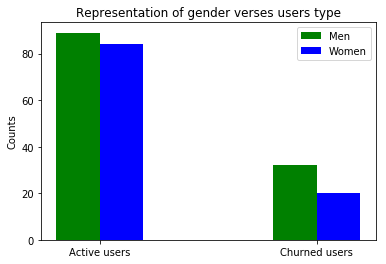

In [62]:
#use the data from above to plot
men=us_gender[us_gender['gender']=='M'].iloc[:,2]
women=us_gender[us_gender['gender']=='F'].iloc[:,2]
#define sizes for plotting histograms
inde=np.arange(len(men))
wid = 0.2
fig, ax = plt.subplots()
rect_col1 = ax.bar(inde - wid/2, men, wid, color='g', label='Men')
rect_col2 = ax.bar(inde + wid/2, women, wid, color='b', label='Women')
#set xlabel and ylabel and title
ax.set_ylabel('Counts')
ax.set_xticks(inde)
ax.set_xticklabels(('Active users', 'Churned users'))
ax.set_title('Representation of gender verses users type')
ax.legend()

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [ ]:
#continued the project in another notebook as I got "java.lang.OutOfMemoryError no enough memory for aggregation"